In [1]:
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns

## Задание 1
### Retention – один из самых важных показателей в компании. Ваша задача – написать функцию, которая будет считать retention   игроков (по дням от даты регистрации игрока).

- Считываем данные

In [2]:
registration = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-il-seregin/shared/problem1-reg_data.csv', sep = ';')
authorisation = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-il-seregin/shared/problem1-auth_data.csv', sep = ';')

- Переводим даты в наглядный формат

In [3]:
registration['reg_ts'] = pd.to_datetime(registration.reg_ts, unit = 's')
authorisation['auth_ts'] = pd.to_datetime(authorisation.auth_ts, unit = 's')

- Соединяем 2 датасета по колонке с id и переводим даты в нужный формат

In [4]:
events_df = authorisation.merge(registration, on = 'uid')
events_df['cohort'] = events_df.reg_ts.astype('datetime64[D]')
events_df['day'] = events_df.auth_ts.astype('datetime64[D]')

- Создаем датесет с когортами по дням регистрации пользователей

In [5]:
cohort_df = events_df.groupby(['cohort', 'day'], as_index=False) \
                  .agg(user_count=('uid', 'nunique'))

- Создаем в датасете колонку с периодами.(кол-во дней от регистраии до повторной авторизации в приложении

In [7]:
cohort_df['period_number'] = (cohort_df.day - cohort_df.cohort) \
                             .dt.days
cohort_df.head(5)

,cohort,day,user_count,period_number
0,1998-11-18,1998-11-18,1,0
1,1999-07-22,1999-07-22,1,0
2,1999-07-22,1999-07-25,1,3
3,1999-07-22,1999-07-31,1,9
4,1999-07-22,1999-08-05,1,14


- Отбираем необходимую часть данных.(указываем когорты, которые нас интересуют, и кол-во дней(period_number), по которым хотим смотреть retention)
- А также переводим дату в строковый формат, чтобы она корректно отображалась на тепловой карте.

In [19]:
cohort_df = cohort_df.query(' "2019-01-01" < cohort <"2019-01-15" and period_number <= 10')


In [20]:
cohort_df["cohort"] = cohort_df["cohort"].astype(str)

- Создаем сводную таблицу из предыдущей, где индексами становятся когорты, колонками становятся периоды, значениями кол-во пользователей.

In [21]:
cohort_pivot = cohort_df \
               .pivot_table(index='cohort',columns = 'period_number', values = 'user_count')

- Переводим кол-во активных пользователей в день в долю от кол-ва зарегистрированных

In [22]:
cohort_size = cohort_pivot.iloc[:, 0]
retention_matrix = cohort_pivot.divide(cohort_size, axis=0)
retention_matrix

period_number,0,1,2,3,4,5,6,7,8,9,10
cohort,,,,,,,,,,,
2019-01-02,1.0,0.017153,0.049743,0.036021,0.049743,0.080617,0.054889,0.070326,0.030875,0.041166,0.042882
2019-01-03,1.0,0.017094,0.030769,0.044444,0.059829,0.063248,0.064957,0.058120,0.022222,0.049573,0.047863
2019-01-04,1.0,0.027350,0.037607,0.042735,0.054701,0.054701,0.080342,0.052991,0.042735,0.052991,0.056410
2019-01-05,1.0,0.018771,0.040956,0.046075,0.049488,0.081911,0.071672,0.069966,0.059727,0.040956,0.047782
2019-01-06,1.0,0.017007,0.037415,0.052721,0.047619,0.059524,0.056122,0.057823,0.052721,0.047619,0.051020
2019-01-07,1.0,0.017007,0.042517,0.040816,0.054422,0.073129,0.073129,0.066327,0.054422,0.054422,0.034014
2019-01-08,1.0,0.030560,0.040747,0.050934,0.057725,0.071307,0.071307,0.066214,0.057725,0.039049,0.049236
2019-01-09,1.0,0.010169,0.027119,0.042373,0.052542,0.059322,0.064407,0.044068,0.057627,0.050847,0.044068
2019-01-10,1.0,0.030457,0.032149,0.050761,0.071066,0.047377,0.059222,0.052453,0.067682,0.038917,0.054146


- Визуализируем матрицу, предварительно высчитав максимальное значение метрики для адаптирования палитры.

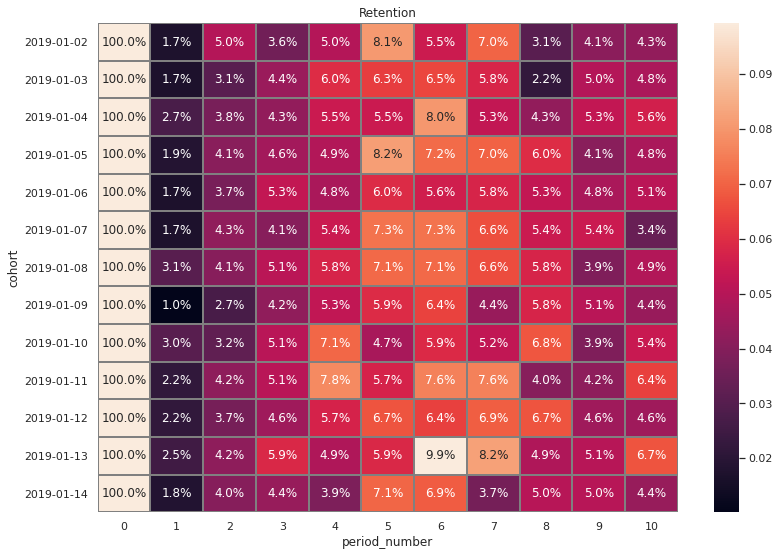

In [25]:
max_retention = retention_matrix.loc[:,1:].max().max()
sns.set(style='white')
plt.figure(figsize=(13, 9))
plt.title('Retention')
sns.heatmap(retention_matrix, annot=True, fmt='.1%', linewidths=1, linecolor='gray', vmax = max_retention);